# DESeq2 with mRNA counts table

[Resources] (http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

In [1]:
options(stringsAsFactors = FALSE)

Load required libraries (install packages if required)

In [1]:
#Load packages
library(limma)
library(edgeR)
library(data.table)
#library(Glimma)
#library(affycoretools)
library(RColorBrewer)
library(gplots)
library(ggplot2)
library(biomaRt)
library(apeglm)
library(DESeq2)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:gplots’:

    space


The following objects are masked from ‘pack

### Creating DESeq2 object

Read in counts file and view head of file

In [2]:
counts<-read.csv("featCounts_mouse_E18.csv",header=TRUE,row.names=1)

In [3]:
head(counts)

,E18_Double_KO_1,E18_Double_KO_2,E18_Double_KO_3,E18_WT_2,E18_WT_3,E18_WT_4
,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693,0,0,1,0,1,1
ENSMUSG00000064842,0,0,0,0,0,0
ENSMUSG00000051951,2,10,3,0,0,2
ENSMUSG00000102851,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0


Make DESeq2 object: Define counts matrix, groups, and design

In [4]:
countData<-as.matrix(counts)
ncol(countData)
colData<-data.frame(condition=c(rep("KO",times=3),rep("WT",times=3)))
nrow(colData)
dds <- DESeqDataSetFromMatrix(countData = countData, colData = colData, design = ~condition)
dds
class(dds)

[1] 6

[1] 6

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 48795 6 
metadata(1): version
assays(1): counts
rownames(48795): ENSMUSG00000102693 ENSMUSG00000064842 ...
  ENSMUSG00000096730 ENSMUSG00000095742
rowData names(0):
colnames(6): E18_Double_KO_1 E18_Double_KO_2 ... E18_WT_3 E18_WT_4
colData names(1): condition

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

### Normalization

Calculate normalization factors and read out normalized counts file. DESeq2 doesn’t actually use normalized counts, rather it uses the raw counts and models the normalization inside the Generalized Linear Model (GLM). These normalized counts will be useful for downstream visualization of results, but cannot be used as input to DESeq2 or any other tools that peform differential expression analysis which use the negative binomial model.

In [5]:
dds <- estimateSizeFactors(dds)
sizeFactors(dds)
normalized_counts <- counts(dds, normalized=TRUE)
write.table(normalized_counts, file="DESeq2normalized_counts_KO_WT.txt", sep="\t", quote=F, col.names=NA)

E18_Double_KO_1 E18_Double_KO_2 E18_Double_KO_3        E18_WT_2        E18_WT_3 
      0.7720591       1.0020726       0.7891916       1.1342045       1.4278679 
       E18_WT_4 
      1.0520437

### Run DESeq2 

In [6]:
#Run DESeq2 
dds<-DESeq(dds)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



1. "alpha" is the significance cutoff used for optimizing the independent filtering (by default 0.1). If the adjusted p-value cutoff (FDR) will be a value other than 0.1, alpha should be set to that value. Here we have set alpha to 0.05.
2. Make table of results and order by adjusted p-value
3. Merge table with normalized coutns file and write out final table

In [7]:
##results dds
##alpha=0.01
res<-results(dds,contrast=c("condition","KO","WT"),alpha=0.01)
##Make table of results
table(res$padj<0.01)
##Order by adjusted p-value
res <- res[order(res$padj),]
##Merge with normalized count data and write out table
resdata <- merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
final<-subset(resdata,resdata$padj<0.01)
write.table(final,file="Mouse_KO_WT_results_alpha0.01.txt",sep="\t")


FALSE  TRUE 
12524  6729 

## Plots

### MA Plot
In DESeq2, the function plotMA shows the log2 fold changes attributable to a given variable over the mean of normalized counts for all the samples in the DESeqDataSet. Points will be colored red if the adjusted p value is less than 0.1. Points which fall out of the window are plotted as open triangles pointing either up or down.

In [8]:
#Log fold change shrinkage for visualization and ranking
resultsNames(dds)
resLFC <- lfcShrink(dds, coef="condition_WT_vs_KO",type="apeglm")
resLFC

[1] "Intercept"          "condition_WT_vs_KO"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): condition WT vs KO 
Wald test p-value: condition WT vs KO 
DataFrame with 48795 rows and 5 columns
                    baseMean log2FoldChange     lfcSE      pvalue        padj
                   <numeric>      <numeric> <numeric>   <numeric>   <numeric>
ENSMUSG00000102693  0.486333      0.0268657  0.984834   0.9168622          NA
ENSMUSG00000064842  0.000000             NA        NA          NA          NA
ENSMUSG00000051951  3.045369     -0.9687264  1.401343   0.0810633     0.15584
ENSMUSG00000102851  0.000000             NA        NA          NA          NA
ENSMUSG00000103377  0.000000             NA        NA          NA          NA
...                      ...            ...       ...         ...         ...
ENSMUSG00000094431      0.00             NA        NA          NA          NA
ENSMUSG00000094621      0.00             NA        NA          NA          NA
ENSMUSG00000098647      0.00             NA        NA          NA          NA
ENSMUSG00000096730 

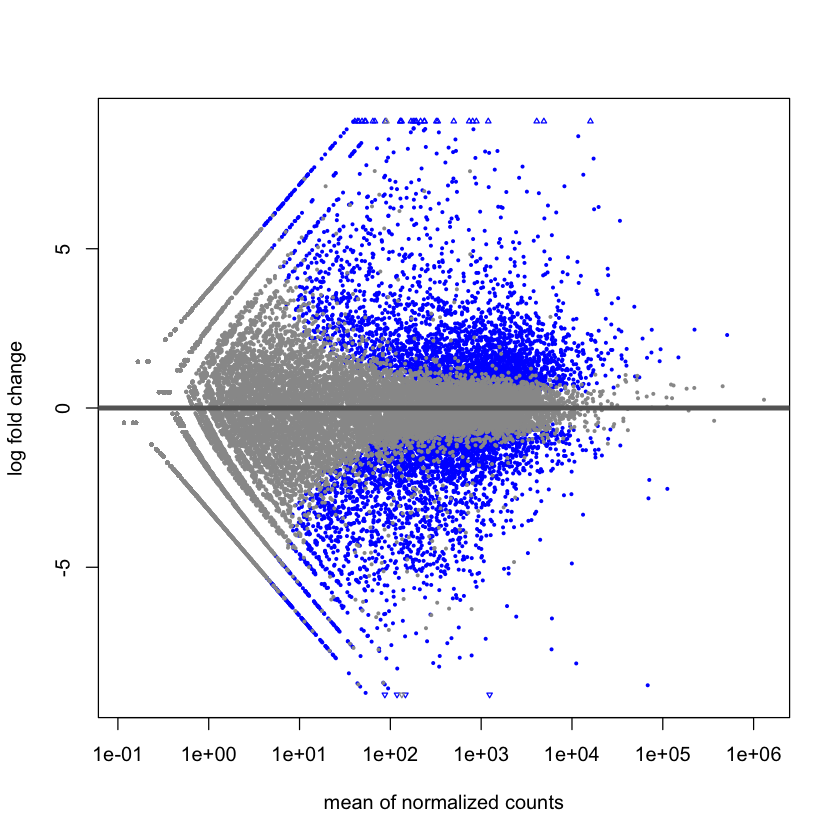

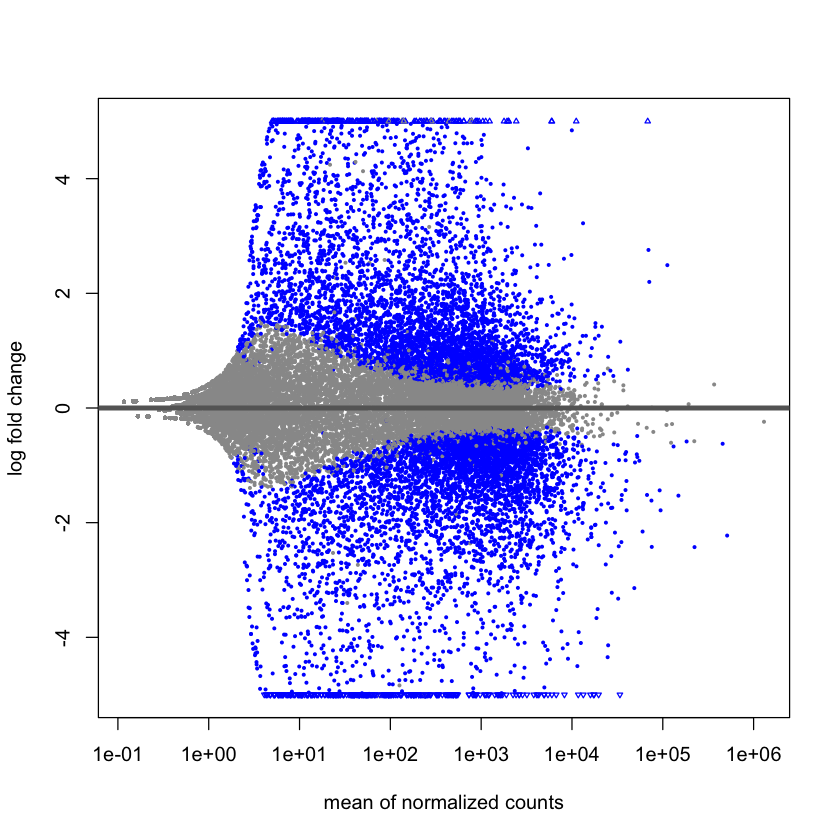

In [9]:
#MA plots
plotMA(res, ylim=c(-9,9))
##It is more useful visualize the MA-plot for the shrunken log2 fold changes, which remove the noise associated with log2 fold changes from low count genes without requiring arbitrary filtering thresholds.
plotMA(resLFC, ylim=c(-5,5))

### PCA Plot
Related to the distance matrix is the PCA plot, which shows the samples in the 2D plane spanned by their first two principal components. This type of plot is useful for visualizing the overall effect of experimental covariates and batch effects.

In [10]:
###function rlog returns a SummarizedExperiment object which contains the rlog-transformed values in its assay slot:
rld <- rlog(dds)
head(rld)

class: DESeqTransform 
dim: 6 6 
metadata(1): version
assays(1): ''
rownames(6): ENSMUSG00000102693 ENSMUSG00000064842 ...
  ENSMUSG00000103377 ENSMUSG00000104017
rowData names(23): baseMean baseVar ... dispFit rlogIntercept
colnames(6): E18_Double_KO_1 E18_Double_KO_2 ... E18_WT_3 E18_WT_4
colData names(2): condition sizeFactor

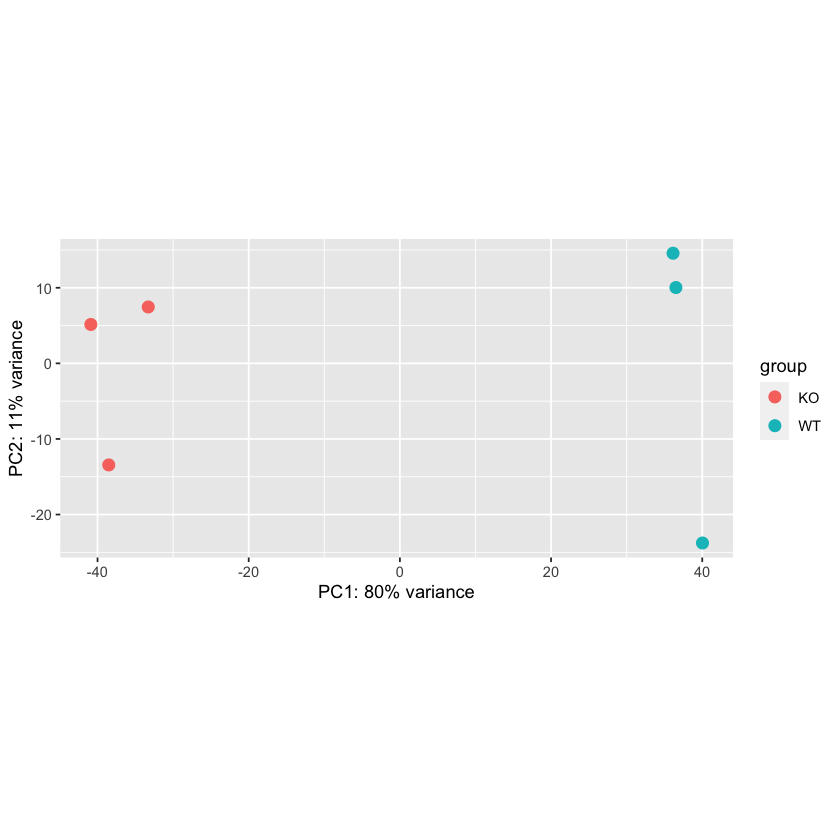

In [11]:
#plot PCA
plotPCA(rld, intgroup = c("condition"))

### Heatmap of sample-to-sample distances
A heatmap of this distance matrix gives us an overview over similarities and dissimilarities between samples. 


,E18_Double_KO_1,E18_Double_KO_2,E18_Double_KO_3
E18_Double_KO_1,0.00000,66.57906,67.70356
E18_Double_KO_2,66.57906,0.00000,83.00071
E18_Double_KO_3,67.70356,83.00071,0.00000


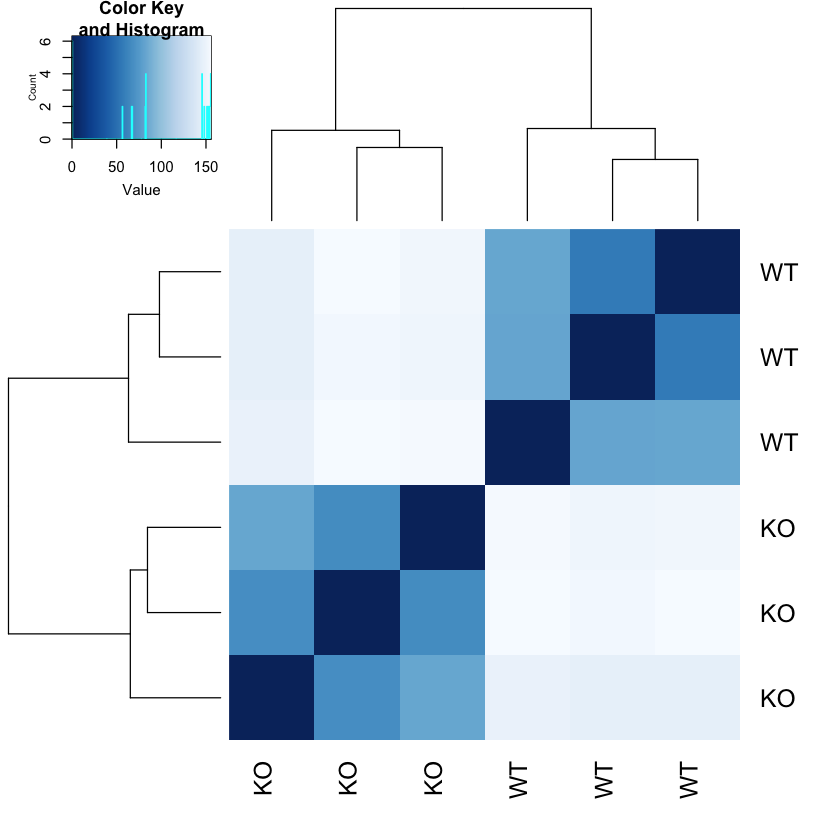

In [12]:
#visualize sample distances
sampleDists <- dist(t(assay(rld)))
as.matrix(sampleDists)[1:3,1:3]
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(rld$condition, sep="-")
colnames(sampleDistMatrix) <- paste(rld$condition, sep="-")
colours = colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
heatmap.2( sampleDistMatrix, trace="none", col=colours)

In [13]:
#biomart
ENSID<-final$Row.names
genes<-ENSID
mart <- useDataset("mmusculus_gene_ensembl", useMart("ensembl"))
attributes<-listAttributes(mart)
G_list <- data.table(getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id", "description","uniprot_gn_symbol"),values=genes,mart= mart))
write.table(G_list,file="biomart_genes_list_DESeq2.txt",sep="\t")


Batch submitting query [===============>---------------]  50% eta:  2s
                                                                      



### Heatmap of mRNAs significantly different between groups
Make heatmaps of all DE mRNAs and top 50 DE mRNAs using heatmap.2

In [14]:
DE_mRNAs<-as.list(final$Row.names)
DE_mRNAs_norm<-subset(normalized_counts,rownames(normalized_counts) %in% DE_mRNAs)
dim(DE_mRNAs_norm)

[1] 6729    6

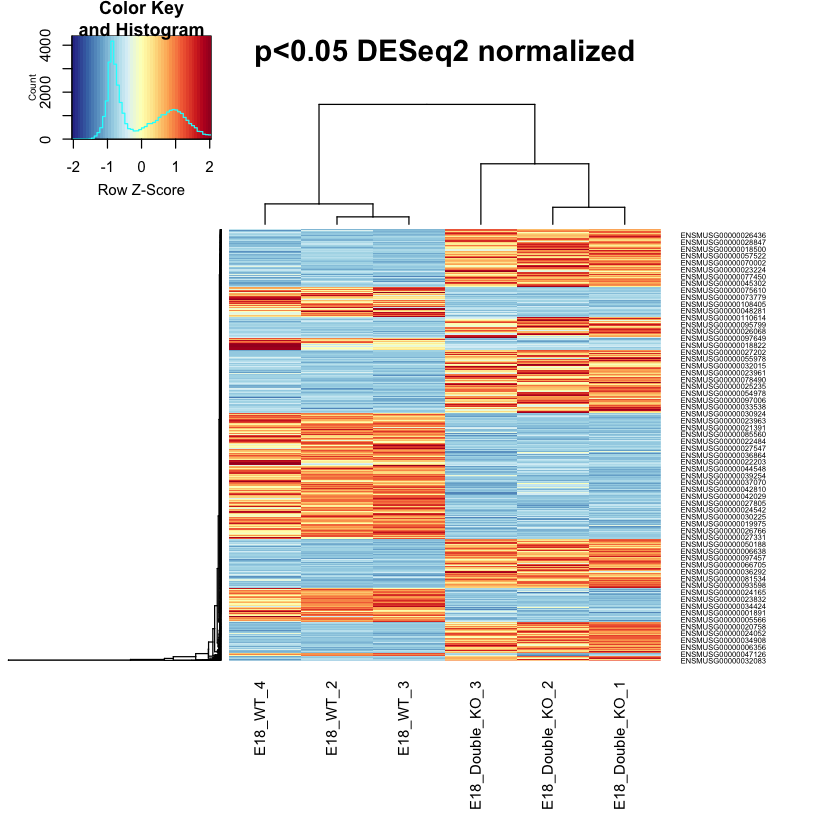

In [15]:
mypalette <- brewer.pal(11,"RdYlBu")
morecols <- colorRampPalette(mypalette)
heatmap.2(DE_mRNAs_norm,col=rev(morecols(50)),trace="none", main="p<0.05 DESeq2 normalized",scale="row",margins=c(9,9), cexCol=0.9)

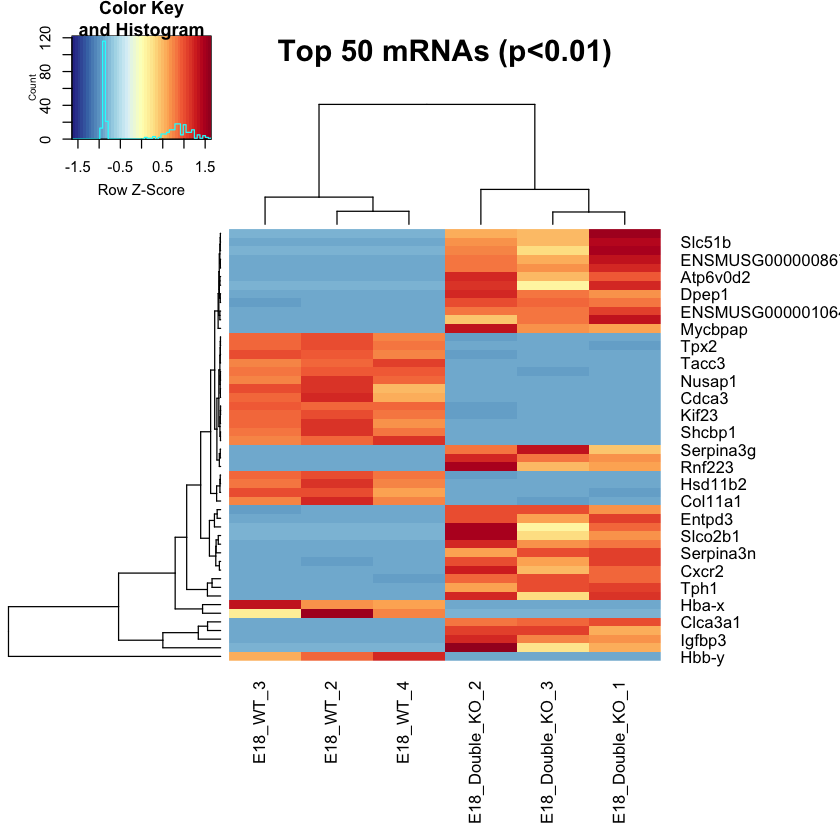

In [16]:
top50<-as.matrix(read.delim("top50_DESeq2.txt",header=TRUE,row.names=1))
mypalette <- brewer.pal(11,"RdYlBu")
morecols <- colorRampPalette(mypalette)
heatmap.2(top50,col=rev(morecols(50)),hclustfun = hclust,trace="none", main="Top 50 mRNAs (p<0.01)",scale="row",margins=c(9,9), cexCol=1,cexRow=1)

### Volcano plot
The volcano plot enables to simultaneously capture the effect size and significance (ordinate) of each tested gene.

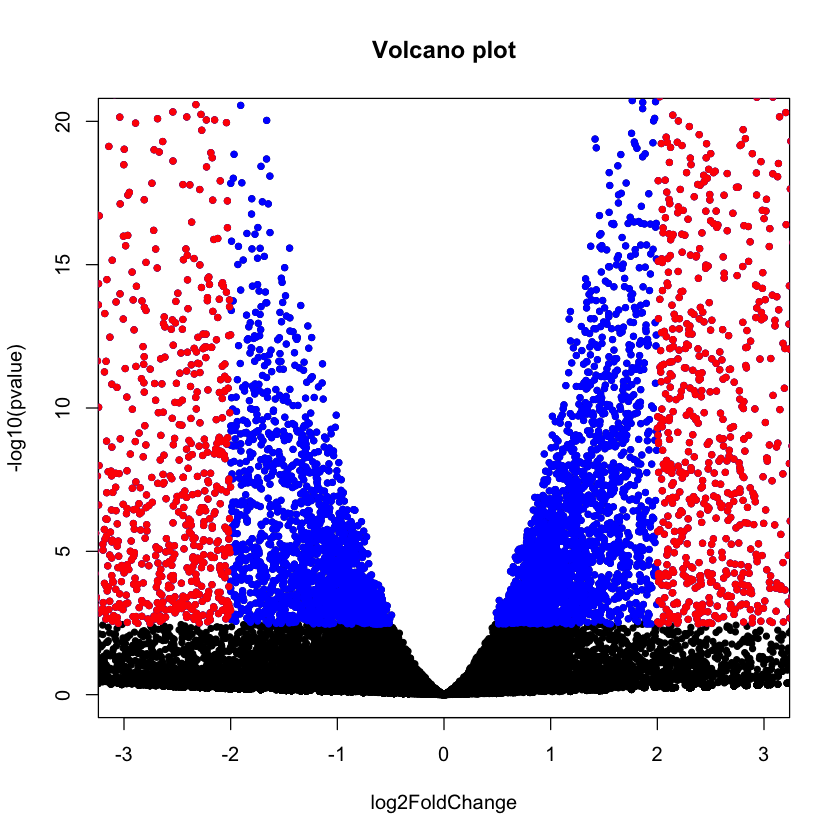

In [17]:
#volcano plot
#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-3,3),ylim=c(0,20)))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))